# part0: imports

In [2]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal
import set_rc_params as set_rc


%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']
reload(dt)
reload(set_rc)

# Global params
set_rc.set_rc_params()
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_ctrl = (-.9, -.45)
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'Str')

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_pull_off',
                                     rel_start=int(-WINDOW_exec[1]/BIN_SIZE),
                                     rel_end=int(-WINDOW_exec[0]/BIN_SIZE)
                                    )

fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                         rel_start=int(WINDOW_ctrl[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_ctrl[1]/BIN_SIZE)
                                        )

In [3]:
def prep_general_mouse (df):
    "preprocessing general! for J. Dudman mouse data"
    # rename unit fields
    old_fields = [col for col in df.columns.values if 'unit' in col]
    new_fields = ['M1_spikes' if 'Ctx' in col else 'Str_spikes' for col in old_fields]
    df_ = df.rename(columns = {old:new for old,new in zip(old_fields,new_fields)})
    # change spikes datatype
    for signal in new_fields:
        df_[signal] = [np.nan_to_num(x=s.toarray().T, nan=0) for s in df_[signal]]
    # add trial_id
    df_['trial_id'] = np.arange(1,df_.shape[0]+1)
    # only keep good trials
    df_= pyal.select_trials(df_, df_.trialType== 'sp')
    # fill no-laser trials (and index fields) with zero
    n_bins = df_[new_fields[0]][0].shape[0]
    var_len_fields = [ 'spkPullIdx', 'spkRchIdx', 'spkTimeBlaserI']
    fill_zeros = lambda a: a if len(a)>1 else np.zeros((n_bins,))
    for field in var_len_fields:
        if field not in df_.columns:continue
        df_[field] = [fill_zeros(s) for s in df_[field]]
    # fill fields that are cut with np.nans and remove trials that are too long or don't exist
    cut_fields = ['hTrjB', 'hVelB']
    df_['badIndex'] = [max(trialT.shape)>n_bins or
                       max(trialV.shape)>n_bins or 
                       max(trialT.shape) < 2 or 
                       max(trialV.shape) < 2 or 
                       np.isnan(trialT).sum() > 5 for trialT,trialV in zip(df_.hTrjB,df_.hVelB)]
    df_= pyal.select_trials(df_, df_.badIndex == False)
    df_.drop('badIndex', axis=1, inplace=True)
    fill_nans = lambda a: a if max(a.shape)==n_bins else np.pad(a, ((0,n_bins-max(a.shape)),(0,0)), 'constant', constant_values=(np.nan,))
    for field in cut_fields:
        if field not in df_.columns:continue
        df_[field] = [fill_nans(s.T) for s in df_[field]]   
    # add bin_size
    df_['bin_size']=0.01  # data has 10ms bin size
    # add idx_movement_on which is exactly at t=df.timeAlign
    df_['idx_movement_on'] = [np.argmin(np.abs(s-i)) for i,s in zip(df_['timeAlign'],df_['spkTimeBins'])]
    # add pull start idx
    df_['idx_pull_on'] = [pullIdx.nonzero()[0][0] if len(pullIdx.nonzero()[0])>0 else np.nan for pullIdx in df_.spkPullIdx]
    # add pull stop idx
    df_['idx_pull_off'] = [pull.nonzero()[0][-1] for pull in df_.spkPullIdx]
    # remove trials with no pull idx
    df_.dropna(subset=['idx_pull_on'], inplace=True)
    df_.idx_pull_on = df_.idx_pull_on.astype(np.int32)
    df_.index = np.arange(df_.shape[0])
    # add target_id
    df_['target_id'] = np.remainder(df_['blNumber'].to_numpy(), 4)

    for signal in new_fields:
        df_ = pyal.remove_low_firing_neurons(df_, signal, 1)
    
    df_= pyal.select_trials(df_, df_.trialType== 'sp')
    try:
        noLaserIndex = [i for i,laserData in enumerate(df_.spkTimeBlaserI) if not np.any(laserData)]
        df_= pyal.select_trials(df_, noLaserIndex)
    except AttributeError:
        # due to absence of this field in no-laser sessions
        pass
    
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in new_fields:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    return df_

# reading data

In [25]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [5]:

full_list_M1 = []
for animal, sessionList in GoodDataList[areas[0]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_M1.append((animal,sessionList))
full_list_M1 = [(animal,session) for animal,sessions in full_list_M1 for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for animal, session in full_list_M1:
    path = root/animal/session
    allDFs_M1.append(prep_general(dt.load_pyal_data(path)))


full_list_PMd = []
for animal, sessionList in GoodDataList[areas[1]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_PMd.append((animal,sessionList))
full_list_PMd = [(animal,session) for animal,sessions in full_list_PMd for session in set(sessions)]
# load the DFs
allDFs_PMd = []
for animal, session in full_list_PMd:
    path = root/animal/session
    allDFs_PMd.append(prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")

if "__file__" not in dir():
    pairFileList_ = []
    for i, (animal1,session1) in enumerate(full_list_M1):
        pairFileList_.append((i,[]))
        for j, (animal2,session2) in enumerate(full_list_PMd):
            if animal1 == animal2: continue
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue
            pairFileList_[-1][1].append(j)
    pairFileList_ = [(i,j) for i,jList in pairFileList_ for j in jList]


    print(f'{len(pairFileList_)=}')

len(pairFileList_)=57


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

In [10]:
if "__file__" not in dir():
    warnings.filterwarnings("ignore")

    side1df = [allDFs_M1[df] for df,_ in pairFileList_]
    side2df = [allDFs_PMd[df] for _,df in pairFileList_]

    AllData1 = dt.get_data_array(side1df, prep_epoch, area='M1', n_components=n_components)
    AllData2 = dt.get_data_array(side2df, fixation_epoch, area='PMd', n_components=n_components)
    # reversing the order of trials to break the target correspondance
    AllData2 = np.flip(AllData2, 1)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

    print(f'{min_trials=}\n{min_time=}')
    warnings.filterwarnings("default")

min_trials=15
min_time=15


do the CCA calculation

In [11]:
if "__file__" not in dir():
    CCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,-min_time:,:], (-1,n_components))
        CCs.append(np.mean(dt.canoncorr(data1, data2)[:4]))
    CCs = np.array(CCs)

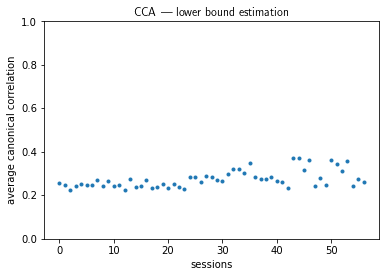

In [12]:
if "__file__" not in dir():
    plt.plot(CCs.T,'.')
    plt.ylim([0,1])
    plt.xlabel('sessions')
    plt.ylabel('average canonical correlation')
    plt.title('CCA --- lower bound estimation', usetex=True);

the average distribution of CCs

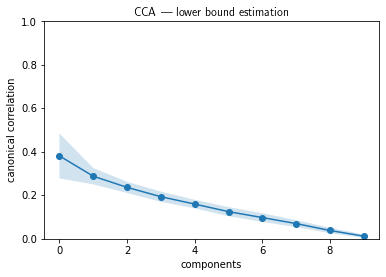

In [15]:
if "__file__" not in dir():

    CCs2=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
        CCs2.append(dt.canoncorr(data1, data2))
    CC_lower_bound = np.array(CCs2).T

    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, CC_lower_bound, marker = 'o')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- lower bound estimation', usetex=True);

## within monkey, within area, across epochs

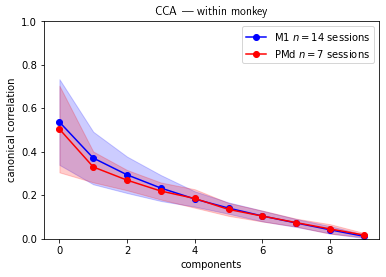

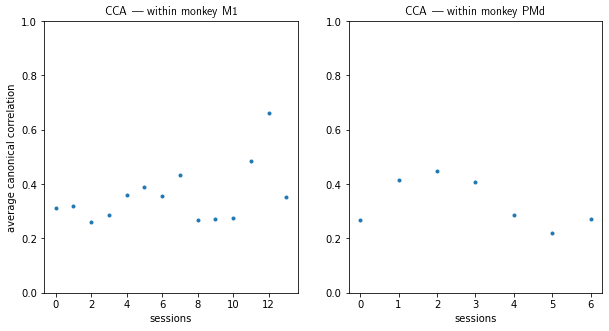

In [8]:
single_FileList1 = []
for I, _ in enumerate(full_list_M1):
    single_FileList1.append(I)

single_FileList2 = []
for I, (animal1,session1) in enumerate(full_list_PMd):
    single_FileList2.append(I)


warnings.filterwarnings("ignore")
#M1
side1df = [allDFs_M1[i] for i in single_FileList1]
AllData1 = dt.get_data_array(side1df, prep_epoch, area=areas[0], n_components=n_components)
AllData1_ = dt.get_data_array(side1df, fixation_epoch, area=areas[0], n_components=n_components)

# PMd
side2df = [allDFs_PMd[j] for j in single_FileList2]
AllData2 = dt.get_data_array(side2df, exec_epoch, area=areas[1], n_components=n_components)
AllData2_ = dt.get_data_array(side2df, fixation_epoch, area=areas[1], n_components=n_components)

warnings.filterwarnings("default")



inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData1_):
    data1 = np.reshape(sessionData1, (-1,n_components))
    data2 = np.reshape(sessionData2, (-1,n_components))
    inCCs0.append(dt.canoncorr(data1, data2))
CC_lower_bound_M1 = np.array(inCCs0).T

inCCs1=[]
for sessionData1,sessionData2 in zip(AllData2,AllData2_):
    data1 = np.reshape(sessionData1, (-1,n_components))
    data2 = np.reshape(sessionData2, (-1,n_components))
    inCCs1.append(dt.canoncorr(data1, data2))
CC_lower_bound_PMd = np.array(inCCs1).T
warnings.filterwarnings("default")

if "__file__" in dir():  # runs when the notebook is being `imported` from another notebook
    print('variables: `CC_lower_bound_M1` and `CC_lower_bound_PMd` hold the lower bound correlations')
    del allDFs_M1, allDFs_PMd, side1df, side2df

# plotting
if "__file__" not in dir():
    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, CC_lower_bound_M1, color='b', marker = 'o', label=f'{areas[0]} $n={CC_lower_bound_M1.shape[1]}$ sessions')
    utility.shaded_errorbar(ax, CC_lower_bound_PMd, color='r', marker = 'o', label=f'{areas[1]} $n={CC_lower_bound_PMd.shape[1]}$ sessions')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.legend()
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- within monkey', usetex=True);

    fig,axes = plt.subplots(ncols=2, figsize=(10,5))
    axes[0].plot(CC_lower_bound_M1[:4,:].mean(axis=0),'.')
    axes[1].plot(CC_lower_bound_PMd[:4,:].mean(axis=0),'.')
    axes[0].set_ylabel('average canonical correlation')
    for i, ax in enumerate(axes):
        ax.set_title(f'CCA --- within monkey {areas[i]} ', usetex=True);
        ax.set_ylim([0,1])
        ax.set_xlabel('sessions')